In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os

import math
from pytorch_pretrained_bert import BertTokenizer
os.chdir('../')
from modeling_readmission import BertForSequenceClassification
import modeling_readmission

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

04/04/2019 17:23:39 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/KexinHuang/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
bert_config = modeling_readmission.BertConfig.from_json_file('../model2/bert_config.json')
model = BertForSequenceClassification(bert_config)

In [6]:
bert_config

{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [7]:
bert_config.num_attention_heads

12

In [9]:
dicts=model.load_state_dict(torch.load('../model2/pytorch_model.bin',map_location='cpu'))

In [10]:
model.bert.encoder.layer[0].attention.self

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1)
)

In [11]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [12]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [13]:
text=' he has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis.'
x,tokens=get_attention_scores(model,0,text)

probability:
tensor([[[[0.0000, 0.0767, 0.0513,  ..., 0.0344, 0.0000, 0.0383],
          [0.0672, 0.0427, 0.0928,  ..., 0.0306, 0.0000, 0.0079],
          [0.0660, 0.0755, 0.0487,  ..., 0.0696, 0.0142, 0.0000],
          ...,
          [0.0101, 0.0216, 0.0000,  ..., 0.0483, 0.0359, 0.0087],
          [0.0242, 0.0332, 0.0665,  ..., 0.0753, 0.0136, 0.0125],
          [0.0000, 0.0325, 0.0939,  ..., 0.0441, 0.0127, 0.0194]],

         [[0.1643, 0.0146, 0.0190,  ..., 0.0131, 0.0261, 0.0067],
          [0.0000, 0.0110, 0.0000,  ..., 0.0534, 0.0000, 0.0043],
          [0.0000, 0.0240, 0.0129,  ..., 0.0216, 0.0000, 0.0016],
          ...,
          [0.0127, 0.0000, 0.0232,  ..., 0.0140, 0.1423, 0.0263],
          [0.1058, 0.0705, 0.0388,  ..., 0.0658, 0.0103, 0.0297],
          [0.0000, 0.1563, 0.0338,  ..., 0.0367, 0.0308, 0.1529]],

         [[0.6386, 0.0544, 0.0195,  ..., 0.0000, 0.0123, 0.0000],
          [0.8415, 0.0226, 0.0185,  ..., 0.0087, 0.0017, 0.0019],
          [0.0000, 0.5207, 0.

probability:
tensor([[[[0.0378, 0.2998, 0.0288,  ..., 0.0026, 0.0056, 0.3353],
          [0.0236, 0.4910, 0.0357,  ..., 0.0015, 0.0037, 0.3308],
          [0.0025, 1.0492, 0.0244,  ..., 0.0000, 0.0001, 0.0118],
          ...,
          [0.0387, 0.0171, 0.0025,  ..., 0.0129, 0.0044, 0.0344],
          [0.0161, 0.0000, 0.0007,  ..., 0.0188, 0.0060, 0.0483],
          [0.0150, 0.0543, 0.0088,  ..., 0.0052, 0.0051, 0.1538]],

         [[0.2483, 0.0326, 0.0300,  ..., 0.0237, 0.0000, 0.2495],
          [0.0088, 0.0652, 0.1884,  ..., 0.0016, 0.0004, 0.0000],
          [0.0000, 0.0070, 0.0558,  ..., 0.0001, 0.0000, 0.0017],
          ...,
          [0.0048, 0.0026, 0.0002,  ..., 0.0000, 0.3849, 0.0000],
          [0.0048, 0.0050, 0.0000,  ..., 0.0116, 0.1059, 0.0000],
          [0.0214, 0.0359, 0.0049,  ..., 0.0163, 0.0826, 0.5616]],

         [[0.2298, 0.0000, 0.0064,  ..., 0.0042, 0.0018, 0.0076],
          [0.0003, 0.0403, 0.7779,  ..., 0.0000, 0.0000, 0.0000],
          [0.0001, 0.0017, 0.

In [14]:
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)

24

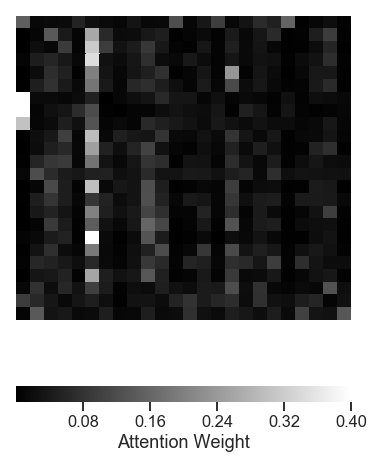

In [15]:
f, ax = plt.subplots(figsize=(6,8))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)

<Figure size 432x288 with 0 Axes>

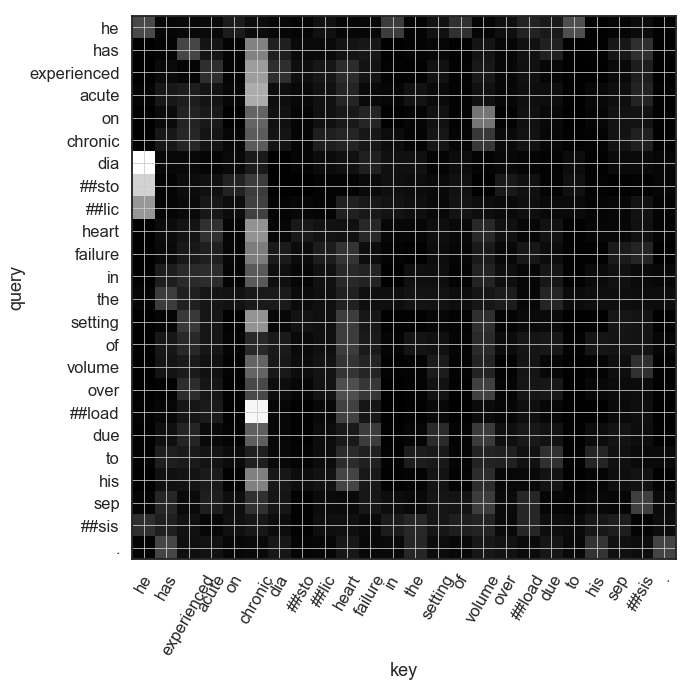

In [16]:
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens,rotation=60)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)

In [ ]:
text = 'confidential notes from mimic iii'
x,tokens=get_attention_scores(model,0,text)
map1=np.asarray(x[0][1].detach().numpy())

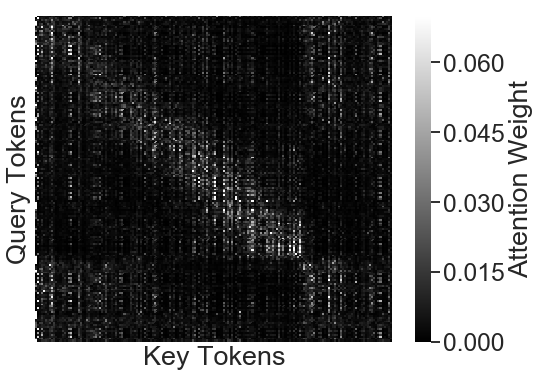

In [112]:
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmin=0, vmax=0.07, cmap='gray', cbar_kws={'label':'Attention Weight'})

ax.set_xlabel('Key Tokens')
ax.set_ylabel('Query Tokens')